In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import os
import pandas as pd
import analyze
from channel_dict import channel_dict

Using TensorFlow backend.


In [376]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [495]:
path = '/home/ershockley/analysis/SPE/data'

earlysr1 = (7000, 7300)
latesr1 = (15000, 15300)

datapaths = {'earlysr1' : [],
             'latesr1' : []}

dataranges = {'earlysr1' : earlysr1,
              'latesr1' : latesr1}

runs = [int(file.split('_')[1].split('.')[0]) for file in os.listdir(path)]

for key, rng in dataranges.items():
    for run in runs:    
        if not (rng[0] <= run <= rng[1]):
            continue
        else:
            datapaths[key].append(os.path.join(path, "run_%05d.h5" % run))

In [496]:
val2corr2 = 0

data = {}
bins = None

for key, pathlist in datapaths.items():
    LED = None
    NOISE = None
    for dpath in pathlist:
        S = analyze.SPE(os.path.join(path, dpath))
        if LED is None:
            bins = S.data['bin_centers']
            LED = S.data['LED_charge']
            NOISE = S.data['noise_charge']
        else:
            LED += S.data['LED_charge']
            NOISE += S.data['noise_charge']
    bin2corr2 = np.where(S.data['bin_centers'] == val2corr2 + 0.5)[0][0]
    corr = LED[:bin2corr2, :].sum(axis=0) / NOISE[:bin2corr2, :].sum(axis=0)
    cNOISE = NOISE * corr
    residual = LED - cNOISE
    occ = -np.log(corr)
    
    data[key] = dict(led=LED, noise=NOISE, cnoise=cNOISE, residual=residual, occ=occ)
    


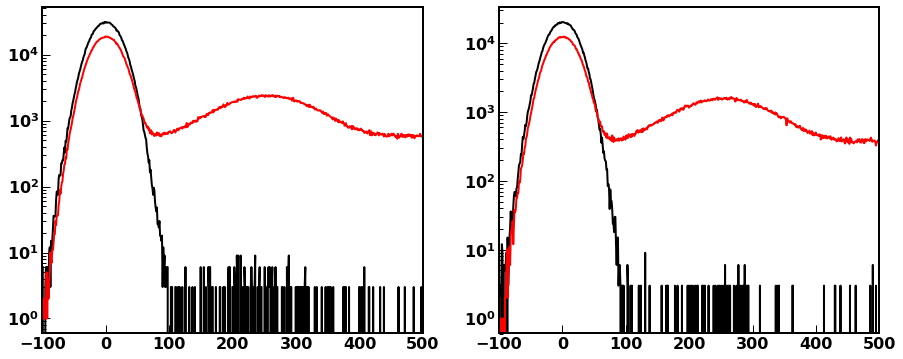

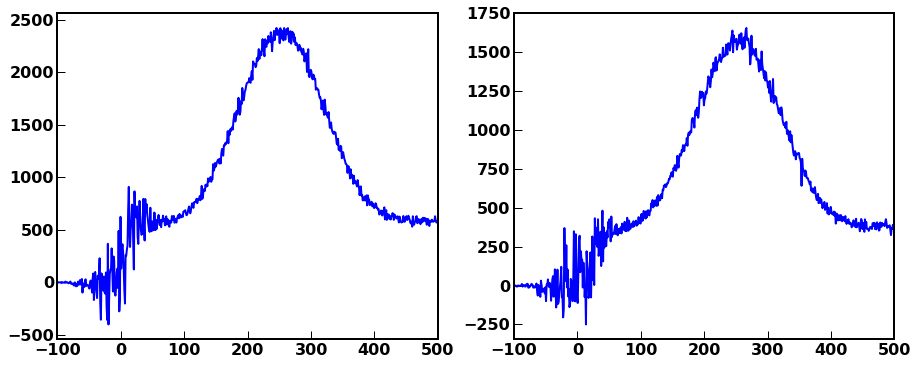

In [497]:
ch = 151

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))  
ax1.plot(bins, data['earlysr1']['noise'][:,ch], color='black')
ax1.plot(bins, data['earlysr1']['led'][:,ch], color='red')
ax1.set_xlim(-100, 500)
ax1.set_yscale('log')
ax2.plot(bins, data['latesr1']['noise'][:,ch], color='black')
ax2.plot(bins, data['latesr1']['led'][:,ch], color='red')
ax2.set_xlim(-100, 500)
ax2.set_yscale('log')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))  
ax1.plot(bins, data['earlysr1']['residual'][:,ch], color='blue')
ax1.set_xlim(-100, 500)
ax2.plot(bins, data['latesr1']['residual'][:,ch], color='blue')
ax2.set_xlim(-100, 500)
plt.show()

In [498]:
from scipy.optimize import curve_fit

def gauss(x, const, mu, sigma):
    G = const * np.exp(-(x-mu)**2 / (2*sigma**2))
    return G

def fit_with_gauss(xdata, ydata, xmin, xmax, first_guess = None):
    fit_xdata = [x for x in xdata if xmin<x<xmax]
    fit_ydata = [y for i,y in enumerate(ydata) if xmin<xdata[i]<xmax]
    assert len(fit_xdata) == len(fit_ydata)
    par_bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
    pars, cov = curve_fit(gauss, fit_xdata, fit_ydata, first_guess, bounds = par_bounds)
    return pars, cov

In [502]:
from scipy.interpolate import UnivariateSpline

def f(b, s, fit, smooth_func, amp, mean, sigma):
    const = 10
    switch_start = mean - sigma - const
    switch_end = mean - sigma
    if b < switch_end:
        if b < -50:
            return 0.0
        elif switch_start < b < switch_end:
            return (1/const)*((b-switch_start)*fit(b, amp, mean, sigma) + (switch_end-b)*smooth_func(b))
        else: # -50 < b < mean - sigma:
            return (smooth_func(b))
        #else:
         #   return s
    else:
        return fit(b, amp, mean, sigma)
    
f = np.vectorize(f, excluded=['fit', 'smooth_func', 'mean', 'sigma'])

spe_distributions = {}
for key, d in data.items():
    spe_dists = []
    off_channels = []
    for ch, (spe, occ) in enumerate(zip(d['residual'].T, d['occ'])):
        #for ch, spe in enumerate(data[key]['residual'][:1,:]):
        #spe = data[key]['residual'][:,ch]
        spe = np.clip(spe, 0, None)
        empirical_mean = (spe*bins).sum() / spe.sum()
        
        if occ < 0.05: # should be an off channel
            spe_dists.append(np.zeros_like(spe))
            off_channels.append(ch)
            continue
            
        fit_region =  (0.5*empirical_mean, 1.5*empirical_mean)
        first_guess = [1e3, empirical_mean, 0.5*empirical_mean]
        try:
            popt,pcov = fit_with_gauss(bins,spe, fit_region[0], fit_region[1], first_guess=first_guess)
            popt, pcov = fit_with_gauss(bins,spe, popt[1]-0.5*popt[2], popt[1]+0.5*popt[2], first_guess=popt)
        except:
            try:
                fit_region =  (0.1*empirical_mean, 2*empirical_mean)
                first_guess = [1e3, empirical_mean, 0.25*empirical_mean]
                popt,pcov = fit_with_gauss(bins,spe, fit_region[0], fit_region[1], first_guess=first_guess)
                popt, pcov = fit_with_gauss(bins,spe, popt[1]-0.5*popt[2], popt[1]+0.5*popt[2], first_guess=popt)
            except:
                f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
                print(key, ch, empirical_mean, occ, first_guess)
                ax1.plot(bins, d['led'][:,ch], color='r')
                ax1.plot(bins, d['noise'][:,ch], color='k')
                ax1.set_xlim(-50, 500)
                ax1.set_yscale('log')
                ax2.plot(bins, spe, color='b')
                ax2.set_xlim(-50, 500)
                plt.show()
                raise
        #fit = [gauss(x, *popt) for x in bins]

        bin2smooth2 = np.where(abs(bins - (popt[1] - 0.75*popt[2])) == np.min(abs(bins - (popt[1] - 0.75*popt[2]))))[0][0]

        smooth = UnivariateSpline(bins[:bin2smooth2], spe[:bin2smooth2], s=3e6)

        #smooth = smooth(bins[:bin2smooth2])
        spe_mod = f(bins, spe, gauss, smooth, *popt)
        spe_dists.append(spe_mod/spe_mod.sum())
    spe_distributions[key] = dict(spe=spe_dists, off_channels=off_channels)

In [503]:
previous = []
for key, d in spe_distributions.items():
    print(key)
    off = d['off_channels']
    extra_off = [ch for ch in off if ch not in ACTUALLY_OFF]
    print('\t', extra_off)


latesr1
	 [137]
earlysr1
	 []


In [514]:
# write files

for key, d in spe_distributions.items():
    with open('%s_spe_charge_pdf.csv' % key, 'w') as f:
        f.write("charge")
        for ch, _ in enumerate(d['spe']):
            f.write(',%d' % ch)
        for b, val in enumerate(bins):
            f.write('%0.1f' % val)
            for ch, ps in enumerate(d['spe']):
                f.write(',%g' % ps[b])
            f.write('\n')
            

In [528]:
# check
import pandas as pd
from scipy.interpolate import interp1d

spe_shapes = pd.read_csv('latesr1_spe_charge_pdf.csv')

# Create a converter array from uniform random numbers to SPE gains (one interpolator per channel)
# Scale the distributions so that they have an SPE mean of 1 and then calculate the cdf

uniform_to_pe_arr = []
for ch in spe_shapes.columns[1:]:  # skip the first element which is the 'charge' header
    if spe_shapes[ch].sum() > 0:
        mean_spe = (spe_shapes['charge'] * spe_shapes[ch]).sum() / spe_shapes[ch].sum()
        scaled_bins = spe_shapes['charge'] / mean_spe
        cdf = np.cumsum(spe_shapes[ch])/np.sum(spe_shapes[ch])
    else:
        # if sum is 0, just make some dummy axes to pass to interpolator
        cdf = np.linspace(0, 1, 10)
        scaled_bins = np.zeros_like(cdf)

    uniform_to_pe_arr.append(interp1d(cdf, scaled_bins))
uniform_to_pe_arr = np.array(uniform_to_pe_arr)

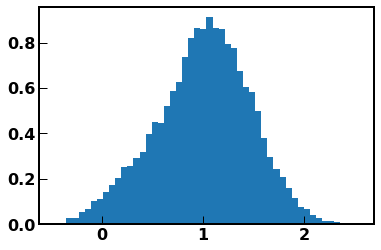

In [529]:
ch = 120
N = 10000
vals = uniform_to_pe_arr[ch](np.random.random(size=N))


plt.hist(vals, bins=50, normed=True)
plt.show()

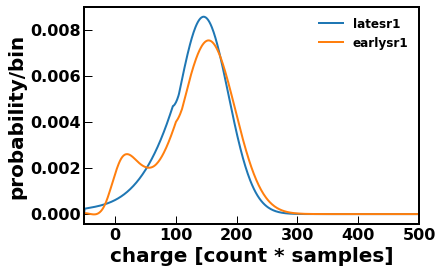

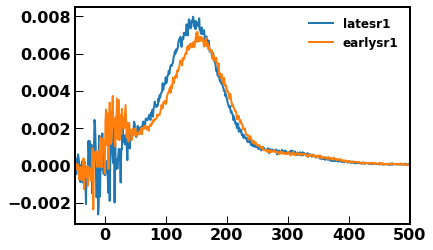

In [535]:
ch = 87

plt.figure(figsize=(6,4))
for key, d in spe_distributions.items():
    plt.plot(bins, d['spe'][ch], label=key)
plt.xlim(-50, 500)
plt.legend(loc='upper right')
plt.xlabel('charge [count * samples]')
plt.ylabel('probability/bin')
plt.savefig('ch%d.png' % ch)

plt.show()

plt.figure(figsize=(6,4))
for key, d in data.items():
    res = d['residual'][:,ch]
    res = res / res.sum()
    plt.plot(bins, res, label=key)
plt.xlim(-50, 500)
plt.legend(loc='upper right')
plt.show()


## Debugging

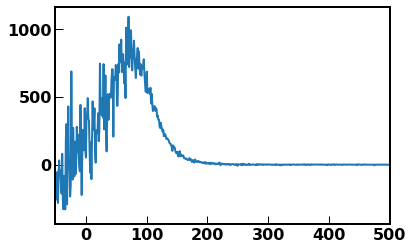

In [402]:
ch = 31
key = 'latesr1'

spe = data[key]['residual'][:,ch]
plt.plot(bins, spe)
plt.xlim(-50, 500)
plt.show()